## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

%matplotlib inline

In [2]:
df = pd.read_csv("train.csv", index_col = 'id')

## Рассмотрим датасет поближе

In [3]:
df.head(5)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
id,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


### Загрузим датасет о пассажиропотоке

In [4]:
ps = pd.read_csv("сount_data.csv", index_col = 0)

In [5]:
ps.head()

,station_nm,line_nm,IncomingPassengers,OutgoingPassengers
1657,Славянский бульвар,Арбатско-Покровская,4678969,4571330
1658,Партизанская,Арбатско-Покровская,1774348,1679955
1659,Народное Ополчение,Большая кольцевая,1492783,1499812
1660,Динамо,Замоскворецкая,2416479,2487168
1661,Медведково,Калужско-Рижская,4397492,4240594


In [6]:
df = df.merge(ps, on=['station_nm','line_nm'], how='left')

In [7]:
ps.drop_duplicates(subset='station_nm', keep='first', inplace=True)

In [8]:
df = df.merge(ps, on=['station_nm'], how='left')

In [9]:
df.drop('line_nm_y', axis =1, inplace = True)

In [10]:
df['IncomingPassengers_x']=df['IncomingPassengers_x'].fillna(df['IncomingPassengers_y'])
df['OutgoingPassengers_x']=df['OutgoingPassengers_x'].fillna(df['OutgoingPassengers_y'])

In [11]:
df.drop(['IncomingPassengers_y', 'OutgoingPassengers_y'], axis =1, inplace = True)
df = df.rename(columns= {'IncomingPassengers_x': 'IncomingPassengers', 
                         'OutgoingPassengers_x': 'OutgoingPassengers',
                         'line_nm_x': 'line_nm'
                        })

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 0 to 1091020
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ticket_id           1091021 non-null  object 
 1   ticket_type_nm      1091021 non-null  object 
 2   entrance_id         1091021 non-null  int64  
 3   entrance_nm         1091021 non-null  object 
 4   station_id          1091021 non-null  int64  
 5   station_nm          1091021 non-null  object 
 6   line_id             1091021 non-null  int64  
 7   line_nm             1091021 non-null  object 
 8   pass_dttm           1091021 non-null  object 
 9   time_to_under       1091021 non-null  float64
 10  label               1091021 non-null  int64  
 11  IncomingPassengers  1091021 non-null  float64
 12  OutgoingPassengers  1091021 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 116.5+ MB


Удалим все id билетов, так как они всегда разные и не могут влиять на предсказание

In [13]:
df.drop('ticket_id', axis =1, inplace = True)

Удалим entrance name, так как она дублирует id станции вхождения. ID входа и ID станции пока оставим и проверим в дальнейшем на корреляцию.

In [14]:
df.drop('entrance_nm', axis =1, inplace = True)

In [15]:
df.drop('station_nm', axis =1, inplace = True)

По той же причине удалим и название линии

In [16]:
df.drop('line_nm', axis =1, inplace = True)

In [17]:
df.head()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label,IncomingPassengers,OutgoingPassengers
0,Пропуск FacePay,2402,11007,11,2022-09-12 05:00:13,216.316667,8001,562076.0,562123.0
1,СК учащегося 30 дней,110,2006,2,2022-09-12 05:00:54,648.183333,9011,3933565.0,3974099.0
2,БСК дружинника г.Москвы,110,2006,2,2022-09-12 05:00:55,865.333333,7022,3933565.0,3974099.0
3,30 дней,110,2006,2,2022-09-12 05:01:13,1048.233333,2022,3933565.0,3974099.0
4,КОШЕЛЕК,110,2006,2,2022-09-12 05:02:55,965.600000,2017,3933565.0,3974099.0


Посмотрим на распределение двух основных величин 

<AxesSubplot:>

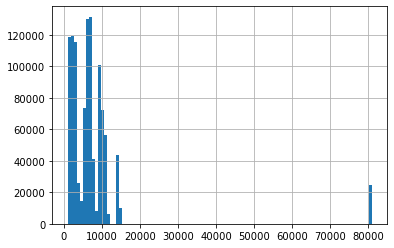

In [18]:
df["label"].hist(bins = 100)

<AxesSubplot:>

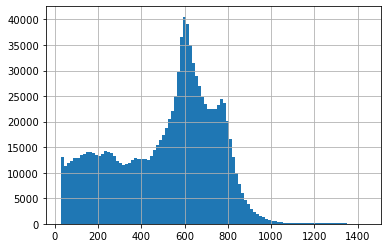

In [19]:
df["time_to_under"].hist(bins = 100)

Найдем наиболее популярную станцию

In [20]:
df["label"].value_counts()

3002     17272
6008     15541
1022     13758
5010     13122
7022     13080
         ...  
13002       24
13003       23
13006       17
13005       14
13004        7
Name: label, Length: 276, dtype: int64

In [21]:
df[df["label"] == int(df["label"].value_counts().index[0])].head()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label,IncomingPassengers,OutgoingPassengers
60,Социальная карта жителя Моск. области,218,8003,8,2022-09-12 05:22:19,677.233333,3002,5897756.0,5693997.0
233,90 дней ЕДИНЫЙ ТК,221,8005,8,2022-09-12 05:28:54,706.883333,3002,3437105.0,3401428.0
307,30 дней ЕДИНЫЙ ТК,2227,10018,10,2022-09-12 05:29:53,792.900000,3002,3777876.0,3683052.0
420,30 дней ЕДИНЫЙ ТК,730,10007,10,2022-09-12 05:30:24,290.266667,3002,1495683.0,1595134.0
526,КОШЕЛЕК,343,7018,7,2022-09-12 05:30:53,829.166667,3002,4218973.0,4140763.0


In [22]:
df[df["station_id"] == int(df["label"].value_counts().index[0])].head()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label,IncomingPassengers,OutgoingPassengers
717,30 дней ЕДИНЫЙ ТК,139,3002,3,2022-09-12 05:32:40,847.133333,3001,4633111.0,4871060.0
818,30 дней,139,3002,3,2022-09-12 05:33:59,905.666667,9009,4633111.0,4871060.0
1090,30 дней,139,3002,3,2022-09-12 05:37:17,873.616667,9005,4633111.0,4871060.0
1728,90 дней ЕДИНЫЙ ТК,139,3002,3,2022-09-12 05:43:19,608.583333,9024,4633111.0,4871060.0
1740,30 дней,139,3002,3,2022-09-12 05:43:26,867.733333,5009,4633111.0,4871060.0


Сделаем категорию **"ticket_type_nm"** числовой

In [23]:
df["ticket_type_nm"].value_counts()

КОШЕЛЕК                                                   262499
30 дней ЕДИНЫЙ ТК                                         177041
Социальная карта москвича                                 127022
30 дней                                                   117064
90 дней ЕДИНЫЙ ТК                                          58071
30 дней СК студента                                        48658
60 поездок ЕДИНЫЙ ТК                                       46542
30 дней Пригород ТК                                        45381
СК студента 30 дней                                        39395
ББК                                                        29674
30 дней СК учащегося                                       24307
365 дней ЕДИНЫЙ ТК                                         20859
СК учащегося 30 дней                                       16933
Социальная карта жителя Моск. области                      15551
90 дней                                                    12817
Пропуск FacePay          

In [24]:
### Произведем mean-target-encoding колонки Тип Билета
keys = dict(df.groupby(['ticket_type_nm'])['time_to_under'].mean())
df['ticket_type_nm'] = df['ticket_type_nm'].map(keys)

In [25]:
df['pass_dttm'] = pd.to_datetime(df['pass_dttm'], format="%Y-%m-%d %H:%M:%S")

In [26]:
df['dayofweek']=df['pass_dttm'].dt.dayofweek

In [27]:
df['day']=df['pass_dttm'].dt.day

In [28]:
df['hour']=df['pass_dttm'].dt.hour

In [29]:
df.drop('pass_dttm', axis =1, inplace = True)

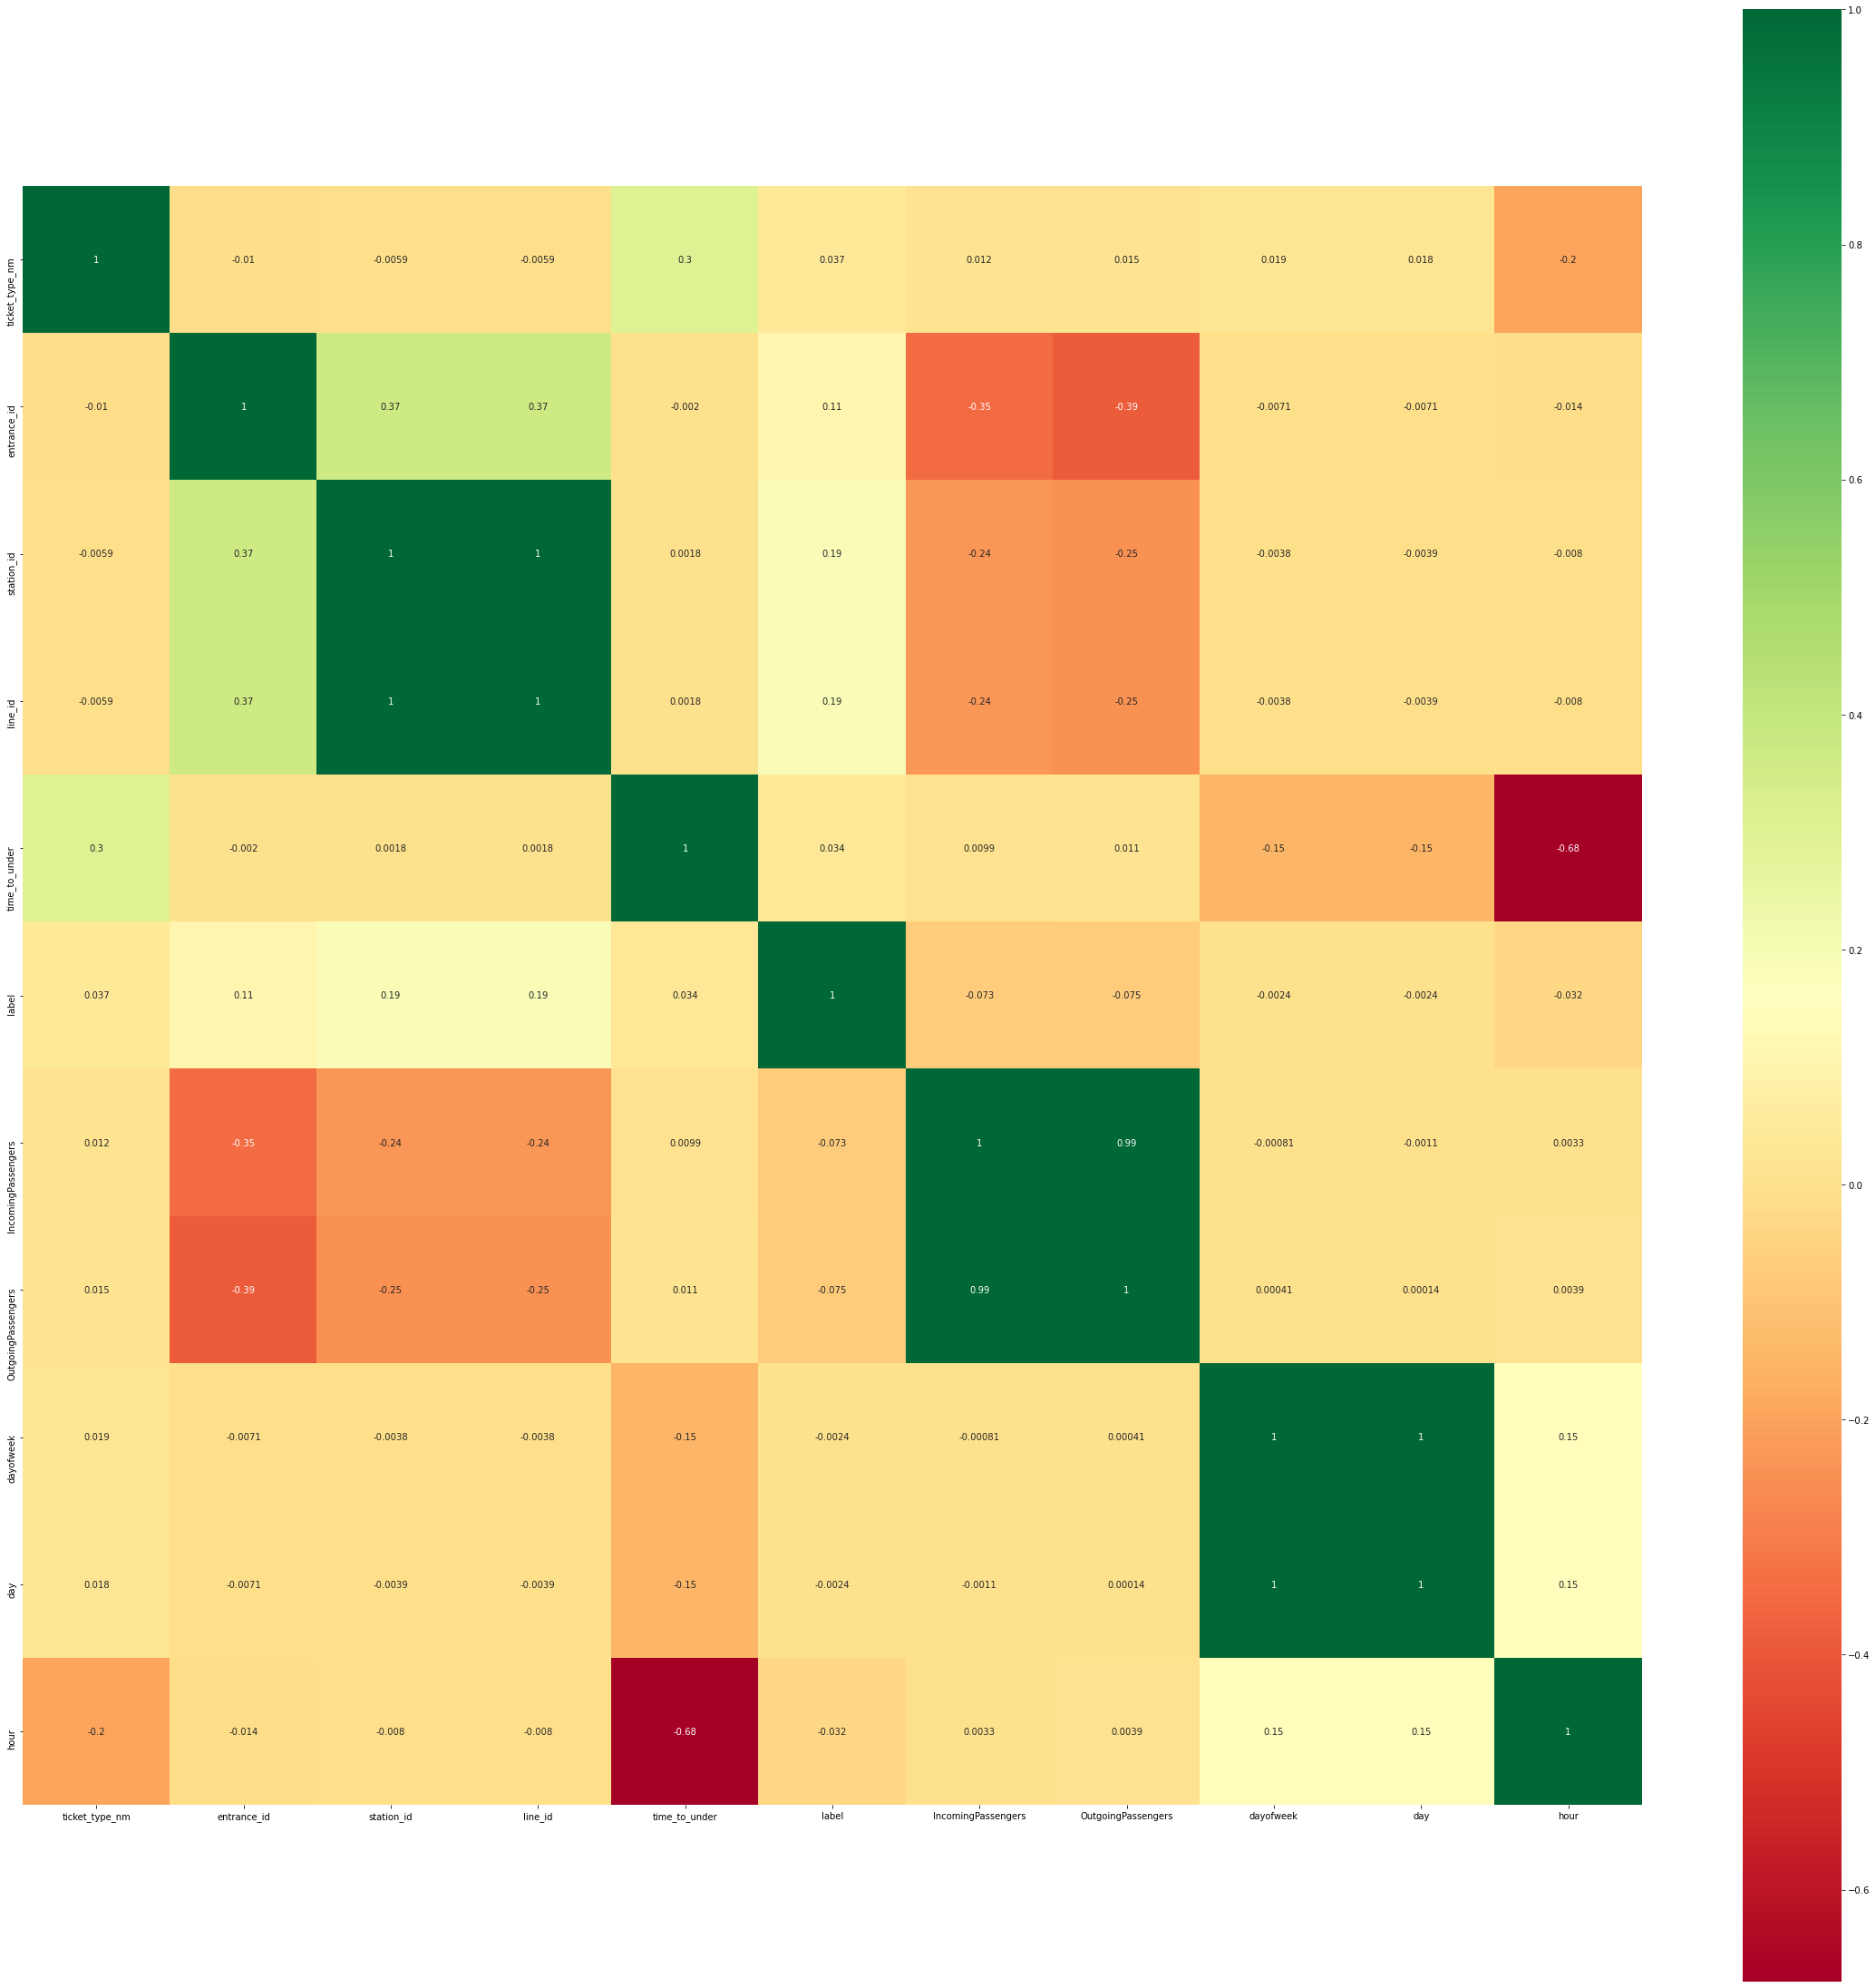

In [30]:
plt.rcParams['figure.figsize']=(40,40)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True, cmap='RdYlGn')

Удалить линию или станцию?

In [31]:
df.drop('line_id', axis =1, inplace = True)

## Выделим выборки

In [32]:
X = df.drop(["time_to_under", "label"], axis = 1)
y = df[["time_to_under", "label"]]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
y_train['label'].value_counts()

3002     12066
6008     10898
1022      9607
7022      9166
5010      9034
         ...  
13002       17
13003       16
13006       14
13005       11
13004        6
Name: label, Length: 276, dtype: int64

## Обучение модели

Для станции 

In [35]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train['label'])

RandomForestClassifier(random_state=42)

Для времени

In [38]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
model_reg = CatBoostRegressor(depth=16, learning_rate= 0.1, iterations =100, random_state=42)
model_reg.fit(X_train, y_train["time_to_under"])

0:	learn: 221.0536346	total: 1.01s	remaining: 1m 40s
1:	learn: 210.9627273	total: 1.82s	remaining: 1m 29s
2:	learn: 202.4634324	total: 1.97s	remaining: 1m 3s
3:	learn: 195.2834487	total: 2.56s	remaining: 1m 1s
4:	learn: 189.1995778	total: 3.1s	remaining: 58.9s
5:	learn: 184.1269087	total: 3.62s	remaining: 56.8s
6:	learn: 179.8416478	total: 4.17s	remaining: 55.4s
7:	learn: 176.2493854	total: 4.69s	remaining: 54s
8:	learn: 173.3246502	total: 5.22s	remaining: 52.8s
9:	learn: 170.9032920	total: 5.5s	remaining: 49.5s
10:	learn: 168.8699080	total: 6.03s	remaining: 48.8s
11:	learn: 167.1985174	total: 6.6s	remaining: 48.4s
12:	learn: 165.8138316	total: 7.14s	remaining: 47.8s
13:	learn: 164.6563472	total: 7.67s	remaining: 47.1s
14:	learn: 163.7011676	total: 8.2s	remaining: 46.5s
15:	learn: 162.9141446	total: 8.73s	remaining: 45.8s
16:	learn: 162.2308982	total: 9.38s	remaining: 45.8s
17:	learn: 161.6675499	total: 9.9s	remaining: 45.1s
18:	learn: 161.2170546	total: 10s	remaining: 42.8s
19:	learn:

## Оценка точности

In [40]:
pred_class = clf.predict(X_test)
pred_reg = model_reg.predict(X_test)

In [42]:
from sklearn.metrics import recall_score, r2_score


score = 0.5 * recall_score(y_test["label"], pred_class , average='macro') +  0.5 * r2_score(y_test["time_to_under"], pred_reg)
score

0.2925071316603968

## Обработка тестового датасета

In [43]:
ps = pd.read_csv("сount_data.csv", index_col = 0)

In [44]:
tst = pd.read_csv("test_dataset_test.csv", index_col = 'id')

In [45]:
ids = tst.index
ids

Int64Index([1091022, 1091023, 1091024, 1091025, 1091026, 1091027, 1091028,
            1091029, 1091030, 1091031,
            ...
            1652902, 1652903, 1652904, 1652905, 1652906, 1652907, 1652908,
            1652909, 1652910, 1652911],
           dtype='int64', name='id', length=561890)

In [46]:
tst = tst.merge(ps, on=['station_nm','line_nm'], how='left')

In [47]:
ps.drop_duplicates(subset='station_nm', keep='first', inplace=True)

In [48]:
tst = tst.merge(ps, on=['station_nm'], how='left')

In [49]:
tst.drop('line_nm_y', axis =1, inplace = True)

In [50]:
tst['IncomingPassengers_x']=tst['IncomingPassengers_x'].fillna(tst['IncomingPassengers_y'])
tst['OutgoingPassengers_x']=tst['OutgoingPassengers_x'].fillna(tst['OutgoingPassengers_y'])

In [51]:
tst.drop(['IncomingPassengers_y', 'OutgoingPassengers_y'], axis =1, inplace = True)
tst = tst.rename(columns= {'IncomingPassengers_x': 'IncomingPassengers', 
                         'OutgoingPassengers_x': 'OutgoingPassengers',
                         'line_nm_x': 'line_nm'
                        })

In [52]:
tst.drop('ticket_id', axis =1, inplace = True)

In [53]:
tst.drop('entrance_nm', axis =1, inplace = True)

In [54]:
tst.drop('station_nm', axis =1, inplace = True)

In [55]:
tst.drop('line_nm', axis =1, inplace = True)

In [56]:
### Произведем mean-target-encoding колонки Тип Билета
tst['ticket_type_nm'].replace(keys, inplace=True)
mean = tst[tst['ticket_type_nm']!='СК студента на 3 месяца']['ticket_type_nm'].mean()
tst['ticket_type_nm'].replace('СК студента на 3 месяца', mean, inplace = True)

In [57]:
tst['pass_dttm'] = pd.to_datetime(tst['pass_dttm'], format="%Y-%m-%d %H:%M:%S")

In [58]:
tst['dayofweek']=tst['pass_dttm'].dt.dayofweek

In [59]:
tst['day']=tst['pass_dttm'].dt.day

In [60]:
tst['hour']=tst['pass_dttm'].dt.hour

In [61]:
tst.drop('pass_dttm', axis =1, inplace = True)

In [62]:
tst.drop('line_id', axis =1, inplace = True)

In [63]:
tst.shape

(561890, 8)

### Предсказание финальное

In [64]:
pred_fin_class = clf.predict(tst)

In [65]:
pred_fin_reg = model_reg.predict(tst)

In [67]:
tst['time_to_under']=pred_fin_reg
tst['label']=pred_fin_class
tst.drop(['ticket_type_nm','entrance_id','station_id','dayofweek',
          'day','hour', 'IncomingPassengers', 'OutgoingPassengers'], axis=1, inplace=True)

In [68]:
tst['id']= ids

In [71]:
tst = tst.set_index('id')

In [72]:
tst.to_csv('solution3.csv')